# Jupyter Notebooks - part 3
* ### Accelerating your Python code

In this lesson you will learn
* how to speed up your Python code with Numba
* how to speed up your Python code with Cython
* how to run code in parallel using ipyparallel

There are various ways to speed up the execution of code in a Jupyter notebook.  
We will start scratching the surface by looking at Numba and Cython

Other ways to increase performance include

- **Numexpr** - a package that speeds up complex array operations (sometimes slow in numpy due to creation of many temporary arrays)
- wrapping C libraries with **ctypes**
- **CFFI** (C Foreign Function Interface for Python)
- **SWIG** (Simplified Wrapper and Interface Generator)
- create a new magic command which compiles C/C++/Fortran code, runs it and returns result!

## Numba

Numpy offers fast vector computations of arrays, but some algorithms can't be vectorized and require explicit loops.  
However, Python loops are slow. `Numba` can speed up Python through a *just-in-time* (JIT) compiler, compiling Python code directly to machine code. 

### Random walk

We first import everything

In [7]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

### <font color="red"> *Exercise*

* Load the random_walk.py example into a cell below
* split up the functions over cells (either via Edit menu or keyboard shortcut). 
* The initialization of `n` and the call to `walk()` don't need to be in a function, and you can remove the `__name__` stuff
* plot the random walk trajectory
* time the execution of `walk()`

In [24]:
# %load random_walk.py


In [8]:
def step():
    return 1. if random.random() > .5 else -1.

In [9]:
def walk(n):
    x = np.zeros(n)
    dx = 1. / n
    for i in range(n - 1):
        x_new = x[i] + dx * step()
        if x_new > 5e-3:
            x[i + 1] = 0.
        else:
            x[i + 1] = x_new
    return x

In [10]:
n = 100000
x = walk(n)

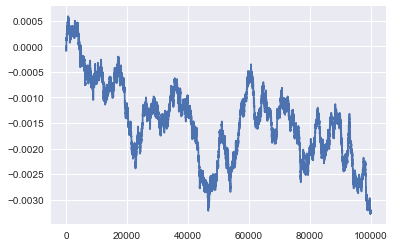

In [11]:
plt.plot(x);

In [31]:
t1 = %timeit -o walk(n)

10 loops, best of 3: 60.4 ms per loop


In [32]:
t1.best

0.06037030220031738

### *Just-in-time* compilation

We import the Numba package, and then add the decorator `@jit` immediately before the function definition

In [62]:
from numba import jit, vectorize, float64

The `nopython=True` argument activates nopython mode, which means that the code is translated directly to machine code, bypassing the CPython interpreter. The nopython mode is faster than python mode, but is more limited and for example lists and dictionaries are not supported. For optimal performance, try to stick with nopython!  

In [28]:
@jit(nopython=True)
def step_numba():
    return 1. if random.random() > .5 else -1.

In [29]:
@jit(nopython=True)
def walk_numba(n):
    x = np.zeros(n)
    dx = 1. / n
    for i in range(n - 1):
        x_new = x[i] + dx * step_numba()
        if x_new > 5e-3:
            x[i + 1] = 0.
        else:
            x[i + 1] = x_new
    return x

`n` is still 10000

In [33]:
t2 = %timeit -o walk_numba(n)

100 loops, best of 3: 2.5 ms per loop


How much faster was the code with just-in-time compilation?

In [35]:
print (t1.best/t2.best)

24.1398101125


Quite a decent speedup!

## Cython

Cython is a superset of Python which supports calling C functions and declaring C types on variables and class attributes.
Cython allows you to
- wrap C/C++ libraries into Python
- optimize Python code by statically compiling with C


We will optimize Python by "cythonizing" it. For wrapping C/C++ libraries, see http://docs.cython.org/en/latest/src/tutorial/

In [60]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [12]:
%%cython?

One can also give compiler flags: `%%cython --compile-args=-fopenmp --link-args=-fopenmp`

### The Mandelbrot fractal 

Initialize variables:

In [39]:
size = 200
iterations = 100

#### Pure python

In [40]:
def mandelbrot_python(m, size, iterations):
    for i in range(size):
        for j in range(size):
            c = -2 + 3./size*j + 1j*(1.5-3./size*i)
            z = 0
            for n in range(iterations):
                if np.abs(z) <= 10:
                    z = z*z + c
                    m[i, j] = n
                else:
                    break

In [46]:
%%timeit -n1 -r1 -o 
m = np.zeros((size, size))
mandelbrot_python(m, size, iterations)

1 loop, best of 1: 1.87 s per loop


<TimeitResult : 1 loop, best of 1: 1.87 s per loop>

In [47]:
t_py = _

#### First cython attempt

First just add the cython magic. The `-a` option activates annotation, which shows "how much Python" there's left in the cythonized code (less yellow means less Python and faster execution)

In [53]:
%%cython -a
import numpy as np

def mandelbrot_cython(m, size, iterations):
    for i in range(size):
        for j in range(size):
            c = -2 + 3./size*j + 1j*(1.5-3./size*i)
            z = 0
            for n in range(iterations):
                if np.abs(z) <= 10:
                    z = z*z + c
                    m[i, j] = n
                else:
                    break

In [54]:
%%timeit -n1 -r1 -o
m = np.zeros((size, size), dtype=np.int32)
mandelbrot_cython(m, size, iterations)

1 loop, best of 1: 1.77 s per loop


<TimeitResult : 1 loop, best of 1: 1.77 s per loop>

In [55]:
t_cy0 = _

Small speedup

#### Second attempt

Now add type information, use *memory views* for NumPy arrays, and replace `np.abs()`

In [57]:
%%cython -a
import numpy as np

def mandelbrot_cython(int[:,::1] m, 
                      int size, 
                      int iterations):
    cdef int i, j, n
    cdef complex z, c
    for i in range(size):
        for j in range(size):
            c = -2 + 3./size*j + 1j*(1.5-3./size*i)
            z = 0
            for n in range(iterations):
                if z.real**2 + z.imag**2 <= 100:
                    z = z*z + c
                    m[i, j] = n
                else:
                    break

We have less yellow!

In [58]:
%%timeit -n1 -r1 -o
m = np.zeros((size, size), dtype=np.int32)
mandelbrot_cython(m, size, iterations)

1 loop, best of 1: 5.47 ms per loop


<TimeitResult : 1 loop, best of 1: 5.47 ms per loop>

In [59]:
t_cy = _

Huge speedup!

### <font color="red"> *Exercise*

1. Take the following Python code which returns prime numbers
2. Run it for `kmax=100` and time it
3. Add the most simple cythonization, using the annotation option
4. Run again and time, compare to pure Python
5. Cythonize it properly! (Hint: replace `p=[]` also). Use annotation, and compare to simple cython
6. Run again and time, compare to pure Python and simple Cython
6. Try just-in-time compilation using `Numba` and compare to Cython

In [20]:
def primes(kmax):  
    p = []
    result = []  
    if kmax > 1000:
        kmax = 1000
    k = 0
    n = 2
    while k < kmax:
        i = 0
        while i < k and n % p[i] != 0:
            i = i + 1
        if i == k:
            p.append(n)
            k = k + 1
            result.append(n)
        n = n + 1
    return result

### <font color="green"> *Solution*

In [3]:
# %load primes_cython.py

NameError: global name 'primes_cython' is not defined

Now the slowest run to "only" 240 times longer than fastest